In [3]:
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path

# Realizamos lectura de todos los estados

In [80]:
# Creo un dict para leer los distintos estados
estados = {}
estados['W'] = 'DataSujetos/W*.csv'
estados['N1'] = 'DataSujetos/N1*.csv'
estados['N2'] = 'DataSujetos/N2*.csv'
estados['N3'] = 'DataSujetos/N3*.csv'

# Loopeo para tener un dataframe anidado con los diferentes estados
filenames = {}
df = {} 

for estado in estados:
    temp = glob(estados[estado])
    filenames[estado] = temp
    df_temp = {}
    for filename in temp:
        name = Path(filename).stem
        temp_df = pd.read_csv(filename, header=None)
        n = temp_df.shape[0]
        temp_df -= np.diag(np.ones(n))
        df_temp[name] = temp_df
    df[estado] = df_temp


In [111]:
#ESTOY TRABAJANDO EN ESTAS LINEAS PARA SACAR PROMEDIOS DE CAMINO MEDIO y OTRAS MEDIDAS DE CENTRALIDAD
#G_obs = nx.from_numpy_matrix(df['W']['W_suj15'].to_numpy, parallel_edges=False)
umbral = 0.5
ws_per = df['W']['W_suj10']
ws_per[ws_per<=umbral] = 0.0

G_per = nx.from_pandas_adjacency(ws_per)

G_obs = nx.from_pandas_adjacency(df['W']['W_suj10'])

#df['W']['W_suj15'].to_numpy

In [112]:
G_obs.number_of_nodes(), G_obs.number_of_edges(), G_per.number_of_nodes(), G_per.number_of_edges()

(116, 4184, 116, 4184)

In [119]:
nx.diameter(G_obs), nx.density(G_obs), nx.average_clustering(G_obs), nx.diameter(G_per), nx.density(G_per), nx.average_clustering(G_per)

(3,
 0.6272863568215892,
 0.8039845474460893,
 3,
 0.6272863568215892,
 0.8039845474460893)

In [139]:
nx.average_shortest_path_length(G_obs)

1.3773613193403298

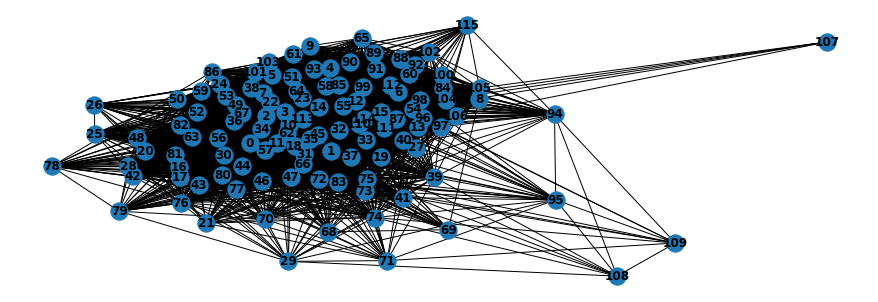

In [122]:
plt.figure(figsize=(12,4))
nx.draw(G_per, with_labels=True, font_weight='bold')

In [121]:
print(nx.info(G_obs))
print('Is weigthed:',nx.is_weighted(G_obs))

Name: 
Type: Graph
Number of nodes: 116
Number of edges: 4184
Average degree:  72.1379
Is weigthed: True


Graficamos una propiedad como el coeficiente de clústering en función de la densidad de aristas

# Calculo de funcion para tener curva promedio
Usamos una función para simplificar

In [43]:
def subjectmatrix2graphslist(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densisdad de aristas correspondiente
    """
    
    correlation_matrix = pd.read_csv(filename, header=None)
    n = correlation_matrix.shape[0]
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
    
    Gs = []
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
    return Gs

In [ ]:
estados = {}
estados['W'] = 'DataSujetos/W*.csv'
estados['N1'] = 'DataSujetos/N1*.csv'
estados['N2'] = 'DataSujetos/N2*.csv'
estados['N3'] = 'DataSujetos/N3*.csv'

densities = np.linspace(0.1,0.9,10)

densities = np.linspace(0.1,0.9,10)

# Loopeamos para tener graphs para cada estado
filenames = {}
graphs = {}

for estado in estados:
    temp = glob(estados[estado])
    filenames[estado] = temp
    graph_temp = {}
    for filename in temp:
        Gs = subjectmatrix2graphslist(filename, densities)
        name = Path(filename).stem
        graph_temp[name] = Gs
    graphs[estado] = graph_temp

Calculamos alguna métrica de los grafos en función de la densidad de aistas para todos los sujetos

In [63]:
avg_clustering = {}
for estado in estados:
    temp_avg_clustering = []
    for name, Gs in graphs[estado].items():
        temp_avg_clustering_ = [nx.average_clustering(G) for G in Gs]
        temp_avg_clustering.append(temp_avg_clustering_)
    temp_avg_clustering = np.vstack(temp_avg_clustering)
    avg_clustering[estado] = temp_avg_clustering

Graficamos todo junto

Graficamos promedios y desvíos con sombra o con barra de error

<Figure size 576x432 with 0 Axes>

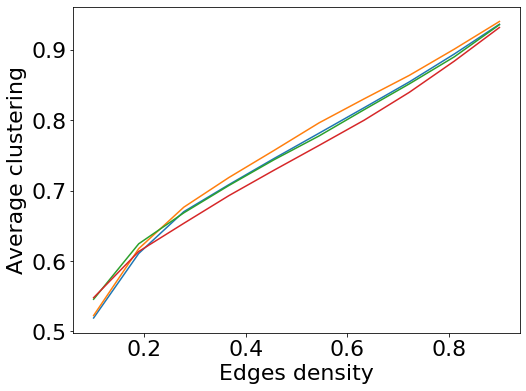

<Figure size 576x432 with 0 Axes>

In [140]:
u={}
s={}
for estado in estados:
    u[estado] = avg_clustering[estado].mean(0)
    s[estado] = avg_clustering[estado].std(0)
    #plt.fill_between(densities,u[estado]-s[estado],u[estado]+s[estado], alpha=0.5);
    #descomentar linea anterior para ver banda de dispersion (hace el grafico muy confuso)
    plt.plot(densities, u[estado]);
    
plt.xlabel('Edges density')
plt.ylabel('Average clustering');

plt.figure()